In [673]:
%matplotlib inline
import sys
import base64
import json
import oauth2 as oauth
import urllib
import pprint
from datetime import datetime
from tlslite.utils import keyfactory
import pymongo
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

jira_server_url = "http://bug.chenyee.com:8080/"
headers = {"Content-Type": "application/json"}


class SignatureMethod_RSA_SHA1(oauth.SignatureMethod):
    name = 'RSA-SHA1'

    def signing_base(self, request, consumer, token):
        if not hasattr(request, 'normalized_url') or request.normalized_url is None:
            raise ValueError("Base URL for request is not set.")

        sig = (
            oauth.escape(request.method),
            oauth.escape(request.normalized_url),
            oauth.escape(request.get_normalized_parameters()),
        )

        key = '%s&' % oauth.escape(consumer.secret)
        if token:
            key += oauth.escape(token.secret)
        raw = '&'.join(sig)
        return key, raw

    def sign(self, request, consumer, token):
        """Builds the base signature string."""
        key, raw = self.signing_base(request, consumer, token)

        with open('/Users/mmuunn/Documents/Works/jira/jira-python-restful/oauth_key/mykey.pem', 'r') as f:
            data = f.read()
        privateKeyString = data.strip()

        privatekey = keyfactory.parsePrivateKey(privateKeyString)
        signature = privatekey.hashAndSign(bytes(raw, 'utf-8'))

        return base64.b64encode(signature)


def get_client_handler():
    consumer_key = 'OauthKey'
    consumer_secret = 'dont_care'
    consumer = oauth.Consumer(consumer_key, consumer_secret)

    access_token = {'oauth_token': 'QHnpXBfHjXhYKfTMVDLMTyInQCefANgv', 'oauth_token_secret': 'k20W95a4ncIhSwBAcvlrXsIQn1IlZzcK'}
    accessToken = oauth.Token(access_token['oauth_token'], access_token[
                              'oauth_token_secret'])
    client = oauth.Client(consumer, accessToken)
    client.set_signature_method(SignatureMethod_RSA_SHA1())

    return client


def get_issues_from_jira(project_key, from_date=None, to_date=None, jira_webclient=None):
    search_url = jira_server_url + 'rest/api/2/search'
    maxResults = 4000  # jira.search.views.default.max
    search_key = {
        "jql": "project = {0} && issuetype = 故障".format(project_key),
        "startAt": 0,
        "maxResults": maxResults,
        "expand":['changelog'],
        "fields": [
            "summary",
            "components",
            "project",
            "reporter",
            "created",
            "priority",
            "customfield_10011",
            "customfield_10012",
            "customfield_10009",
            "assignee",
            "status",
            "updated",
            "resolution",
            "resolutiondate"
        ]
    }

    # get total issue
    resp, content = jira_webclient.request(method="POST", uri=search_url, headers=headers,
                                           body=bytes(json.dumps(search_key), 'utf-8'))
    issues_list = []
    if resp.status == 200:
        issues = json.loads(content)
        issues_list.append(issues)
        total = issues['total']
        print("total issues is {0}".format(issues['total']))
        if total > maxResults:
            round = int(total/maxResults)
            for i in range(0, round):
                print("get more issues at round {0}".format(i))

                search_key['startAt'] = maxResults*(i+1)
                resp, content = jira_webclient.request(method="POST", uri=search_url, headers=headers, body=bytes(json.dumps(search_key), 'utf-8'))
                if resp.status == 200:
                    issues = json.loads(content)
                    issues_list.append(issues)
                else:
                    print("error with {0}".format(resp.status))
    else:
        print("error with {0}".format(resp.status))

    return issues_list

def convert_changelog(changelog):
    changelog_mongodb = []
    
    for history in changelog['histories']:
        h = {}
        h['author'] = history['author']['name']
        h['date'] = datetime.strptime(history['created'], "%Y-%m-%dT%H:%M:%S.%f+0800")
        
        h['items'] = []
        for item in history['items']:
            #just get status change historys
            if item['field'] == 'status':
                value = {'field':item['field'], 'from':item['fromString'], 'to':item['toString']}
                h['items'].append(value)
            elif item['field'] == 'assignee':
                value = {'field':item['field'], 'from':item['from'], 'to':item['to']}
                h['items'].append(value)
                
        if h['items'] != []:
            changelog_mongodb.append(h)
    
    return changelog_mongodb
    
def convert_data(issue):
    issue_for_mongodb = {}
    issue_for_mongodb['key'] = issue['key']
    issue_for_mongodb['project'] = issue['fields']['project']['key']
    issue_for_mongodb['component'] = issue['fields']['components'][0]['name']
    if issue['fields']['assignee'] is not None:
        try:
            issue_for_mongodb['assignee'] = {'name': issue['fields']['assignee']['name'],
                                     'displayName': issue['fields']['assignee']['displayName'], 
                                         'dept': dept_dict[issue['fields']['assignee']['name']]}
        except KeyError:
            print("not found key: {}".format(issue['fields']['assignee']['name']))
            
    else:
        issue_for_mongodb['assignee'] = None
    issue_for_mongodb['reporter'] = {'name': issue['fields']['reporter']['name'],
                                     'displayName': issue['fields']['reporter']['displayName']}
    issue_for_mongodb['summary'] = issue['fields']['summary']
    issue_for_mongodb['status'] = issue['fields']['status']['name']
    issue_for_mongodb['priority'] = issue['fields']['priority']['name']
    issue_for_mongodb['probability'] = issue['fields']['customfield_10011']['value']
    issue_for_mongodb['severity'] = issue['fields']['customfield_10009']['value']
    issue_for_mongodb['phenomenon'] = issue['fields']['customfield_10012']['value']

    if issue['fields']['resolution'] != None:
        issue_for_mongodb['resolution'] = {'how': issue['fields']['resolution']['name'],
                                           'when': datetime.strptime(issue['fields']['resolutiondate'], "%Y-%m-%dT%H:%M:%S.%f+0800")}
    else:
        issue_for_mongodb['resolution'] = {'how': None, 'when': None}

    issue_for_mongodb['created_time'] = datetime.strptime(issue['fields']['created'], "%Y-%m-%dT%H:%M:%S.%f+0800")
    issue_for_mongodb['updated_time'] = datetime.strptime(issue['fields']['updated'], "%Y-%m-%dT%H:%M:%S.%f+0800")

    if issue_for_mongodb['status'] == 'Closed':
        issue_for_mongodb['closed_time'] = issue_for_mongodb['updated_time']
    else:
        issue_for_mongodb['closed_time'] = None

    issue_for_mongodb['change_logs'] = convert_changelog(issue['changelog'])
    
    return issue_for_mongodb


In [633]:
client = pymongo.MongoClient()
cydb = client.cy

In [669]:
depts = cydb.dept.find(projection={'name':1, 'dept':1, '_id':0})

dept_dict = {}
for dept in depts:
    dept_dict[dept['name']] = dept['dept'].split('/')[1]

In [674]:
issue_list = []
jira_webclient = get_client_handler()
issues_list = get_issues_from_jira('CSW1702A', jira_webclient=jira_webclient)


for issues in issues_list:
    for issue in issues['issues']:
        issue_list.append(convert_data(issue))

total issues is 1339
not found key: xinyan.yi
not found key: zhong.zhu
not found key: zhong.zhu


In [675]:
issues_list = get_issues_from_jira('CSW1705A', jira_webclient=jira_webclient)

for issues in issues_list:
    for issue in issues['issues']:
        issue_list.append(convert_data(issue))

total issues is 469
not found key: lingyu.yang


In [676]:
issues_list = get_issues_from_jira('SW17W16A', jira_webclient=jira_webclient)

for issues in issues_list:
    for issue in issues['issues']:
        issue_list.append(convert_data(issue))

total issues is 2743
not found key: xinyan.yi
not found key: xinyan.yi
not found key: xinyan.yi
not found key: xinyan.yi
not found key: xinyan.yi
not found key: xinyan.yi
not found key: xinyan.yi
not found key: xinyan.yi
not found key: xinyan.yi
not found key: xinyan.yi
not found key: xinyan.yi
not found key: xinyan.yi
not found key: lingyu.yang
not found key: lingyu.yang


In [677]:
ret = cydb.issues.drop()

In [678]:
print(ret)

None


In [679]:
cydb.issues.insert_many(issue_list)

In [701]:
pipeline = [ {'$project':{'key':'$key', 'project':'$project', 'assignee':'$assignee.displayName', 'dept':'$assignee.dept', 'status':'$status','created':'$created_time', 'priority':'$priority'}}, {"$sort":{'assignee':1}}]

In [749]:
issues = cydb.issues.aggregate(pipeline)

In [750]:
issue_pd = pd.DataFrame(list(issues))
del issue_pd['_id']

In [751]:
unresolved_issue = issue_pd[issue_pd.status.isin(['Open', 'Reopened','In Progress','Assigned'])]

In [752]:
aa = unresolved_issue.groupby(['project', 'priority']).count()['key']

In [753]:
bb = aa.unstack()

In [754]:
bb

priority,P1-Highest,P2-High,P3-Medium,P4-Low
project,,,,
CSW1702A,105.0,367.0,NaN,NaN
CSW1705A,90.0,174.0,5.0,NaN
SW17W16A,71.0,312.0,2.0,1.0


In [708]:
sns.set(style="dark", palette=sns.dark_palette("red", reverse=True))

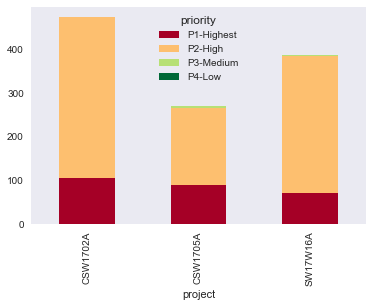

In [709]:
project = bb.plot(kind='bar', stacked=True, colormap='RdYlGn')

In [572]:
project.figure.savefig("project.pdf")

In [710]:
users = unresolved_issue.groupby(['assignee']).count()['key']

In [712]:
plt.rcParams['font.sans-serif']=['SimHei']

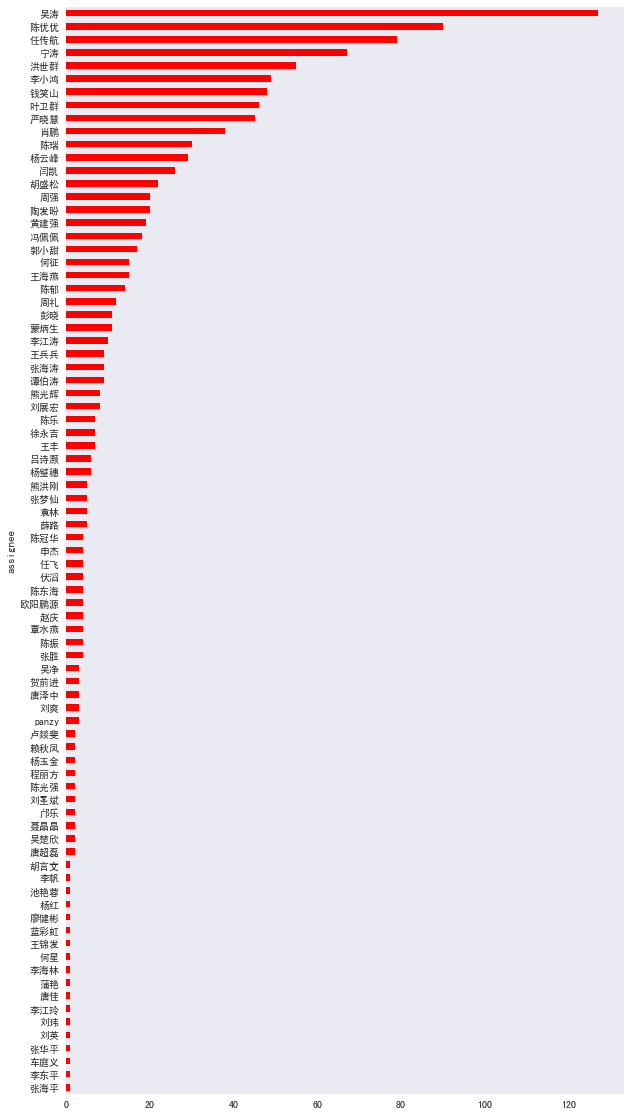

In [713]:
pp = users.sort_values().plot(kind='barh', figsize=(10,20))

In [715]:
pp.figure.savefig("user.pdf")

In [714]:
depts = unresolved_issue.groupby(['dept']).count()['key']


In [694]:
plt.rcParams['font.sans-serif']=['SimHei']

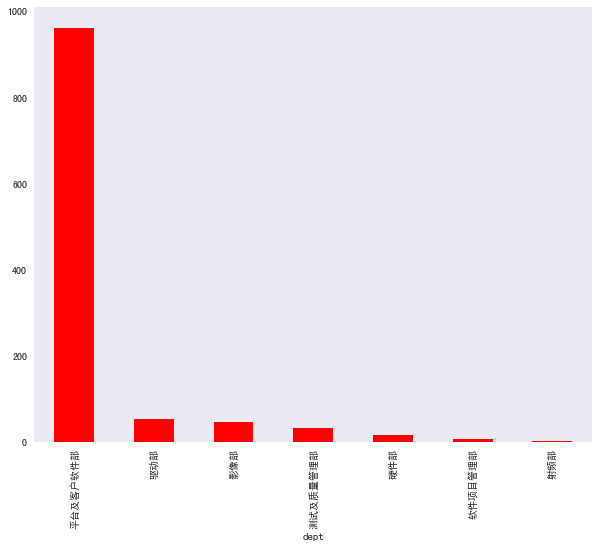

In [700]:
pp = depts.sort_values(ascending=False).plot(kind='bar', figsize=(10,8))

In [698]:
pp.figure.savefig("dept.pdf")

In [757]:
issue_pd_created = issue_pd.set_index('created')

In [733]:
issue_pd['created'] = issue_pd['created'].dt.normalize()

In [761]:
create_issue = issue_pd.groupby(['created']).count()['key']

In [791]:
create_issue

DatetimeIndex(['2017-10-11 18:04:44', '2017-10-11 18:24:39',
               '2017-10-11 19:34:18', '2017-10-11 19:38:34',
               '2017-10-12 09:39:45', '2017-10-12 09:43:32',
               '2017-10-12 10:07:38', '2017-10-12 10:11:43',
               '2017-10-12 10:14:01', '2017-10-12 10:22:20',
               ...
               '2018-01-09 15:36:16', '2018-01-09 15:39:24',
               '2018-01-09 15:41:09', '2018-01-09 15:43:43',
               '2018-01-09 15:44:53', '2018-01-09 15:48:48',
               '2018-01-09 16:02:19', '2018-01-09 16:03:40',
               '2018-01-09 16:08:35', '2018-01-09 16:13:39'],
              dtype='datetime64[ns]', name='created', length=4499, freq=None)

In [794]:
h4_resample = create_issue.resample('D').sum()

In [795]:
x = 

created
2017-10-11      4.0
2017-10-12     30.0
2017-10-13      1.0
2017-10-14      NaN
2017-10-15      NaN
2017-10-16      2.0
2017-10-17      5.0
2017-10-18     14.0
2017-10-19     14.0
2017-10-20     14.0
2017-10-21      NaN
2017-10-22      NaN
2017-10-23      2.0
2017-10-24     78.0
2017-10-25     81.0
2017-10-26     91.0
2017-10-27     86.0
2017-10-28      7.0
2017-10-29      1.0
2017-10-30     50.0
2017-10-31     60.0
2017-11-01    241.0
2017-11-02     29.0
2017-11-03     32.0
2017-11-04      NaN
2017-11-05      NaN
2017-11-06     26.0
2017-11-07     33.0
2017-11-08     63.0
2017-11-09     57.0
              ...  
2017-12-11     84.0
2017-12-12    114.0
2017-12-13     74.0
2017-12-14     87.0
2017-12-15     47.0
2017-12-16     33.0
2017-12-17      NaN
2017-12-18     67.0
2017-12-19     65.0
2017-12-20     72.0
2017-12-21     41.0
2017-12-22     57.0
2017-12-23     40.0
2017-12-24      NaN
2017-12-25     52.0
2017-12-26     73.0
2017-12-27     68.0
2017-12-28    163.0
2017-12-29  

In [787]:
plt.bar(data=h4_resample)

TypeError: bar() missing 2 required positional arguments: 'left' and 'height'

In [799]:
depts_all = list(cydb.dept.find())

In [800]:
depts_all

[{'_id': ObjectId('5a5466dee6cb221888cd9f1f'),
  'dept': '默认部门/',
  'displayName': '陆文超',
  'email': 'luwenchao@chenyee.com',
  'name': 'luwenchao'},
 {'_id': ObjectId('5a5466dee6cb221888cd9f20'),
  'dept': '默认部门/',
  'displayName': '何鸿键',
  'email': 'hungkin.ho@chenyee.com',
  'name': 'hungkin.ho'},
 {'_id': ObjectId('5a5466dee6cb221888cd9f21'),
  'dept': '硬件研发中心/硬件部/',
  'displayName': '谢峰',
  'email': 'xiefeng@chenyee.com',
  'name': 'xiefeng'},
 {'_id': ObjectId('5a5466dee6cb221888cd9f22'),
  'dept': '人力行政市场中心/总裁办/',
  'displayName': '贺正平',
  'email': 'hezp@chenyee.com',
  'name': 'hezp'},
 {'_id': ObjectId('5a5466dee6cb221888cd9f23'),
  'dept': '软件及互联网研发中心/平台及客户软件部/',
  'displayName': '周强',
  'email': 'zhouqiang@chenyee.com',
  'name': 'zhouqiang'},
 {'_id': ObjectId('5a5466dee6cb221888cd9f24'),
  'dept': '品牌及新业务中心/',
  'displayName': '徐承科',
  'email': 'ryanxu@chenyee.com',
  'name': 'ryanxu'},
 {'_id': ObjectId('5a5466dee6cb221888cd9f25'),
  'dept': '软件及互联网研发中心/平台及客户软件部/',
  'dis

In [801]:
client_209 = pymongo.MongoClient('18.8.8.209')

In [802]:
client_209

MongoClient(host=['18.8.8.209:27017'], document_class=dict, tz_aware=False, connect=True)

In [803]:
db = client_209.cy

In [804]:
db.dept.insert_many(depts_all)

In [805]:
import os

In [808]:
os.path.basename("bbb")

'bbb'